<a href="https://colab.research.google.com/github/AmandaPCerqueira/P-s/blob/main/An%C3%A1lise_de_cr%C3%A9dito__V7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise de risco de crédito do cliente bancário**

Problema: Evitar a inadimplência nas operações de crédito bancário

Objetivo: O modelo deverá ser capaz de prever uma possível inadimplência, com base no perfil do cliente(dados pessoais e vida finaceira), possibilitando ao banco agir de forma preventiva, visando garantir a saúde financeira da instituição.  

A coluna do dataset que querermos prever é a "default", onde 1 representa o SIM (possível inadimplente) e 0, representa o NÃO (adimplente)



Instalando as bibliotecas necessárias ao modelo

In [ ]:
!pip install pandas scikit_learn ensemble matplotlib numpy

Fazendo os imports necessários

In [3]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model, decomposition, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos
from sklearn.linear_model import LogisticRegression # Regressão Logística, para a Eliminação Recursiva de Atributos

Importando o dataset (o arquivo foi colocado em um repositório do meu github e foi referenciado abaixo na sua versão raw)



In [4]:
import pandas as pd
tabela = pd.read_csv('https://raw.githubusercontent.com/AmandaPCerqueira/P-s/main/credito.csv')
print(tabela)


              id  default  idade sexo  dependentes         escolaridade  \
0      768805383        0     45    M            3         ensino medio   
1      818770008        0     49    F            5             mestrado   
2      713982108        0     51    M            3             mestrado   
3      769911858        0     40    F            4         ensino medio   
4      709106358        0     40    M            3  sem educacao formal   
...          ...      ...    ...  ...          ...                  ...   
10122  772366833        0     50    M            2             mestrado   
10123  710638233        1     41    M            2                   na   
10124  716506083        1     44    F            1         ensino medio   
10125  717406983        1     30    M            2             mestrado   
10126  714337233        1     43    F            2             mestrado   

      estado_civil   salario_anual tipo_cartao  meses_de_relacionamento  \
0           casado     $

Verificando as informação do dataset para início do tratamento de dados



In [5]:
print(tabela.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       10127 non-null  int64 
 1   default                  10127 non-null  int64 
 2   idade                    10127 non-null  int64 
 3   sexo                     10127 non-null  object
 4   dependentes              10127 non-null  int64 
 5   escolaridade             10127 non-null  object
 6   estado_civil             10127 non-null  object
 7   salario_anual            10127 non-null  object
 8   tipo_cartao              10127 non-null  object
 9   meses_de_relacionamento  10127 non-null  int64 
 10  qtd_produtos             10127 non-null  int64 
 11  iteracoes_12m            10127 non-null  int64 
 12  meses_inativo_12m        10127 non-null  int64 
 13  limite_credito           10127 non-null  object
 14  valor_transacoes_12m     10127 non-nul

Foi identificado que não tem temos nenhuma informação vazia ou com formato errado, porém, como se trata de um problema de classificação, será necessário tratar as colunas com o tipo de informação "object"

Esse tratamento será realizado com o LabelEncoder

In [6]:
from sklearn.preprocessing import LabelEncoder
# vai transformar as colunas de texto em números
codificador = LabelEncoder()

for coluna in tabela.columns:
    if tabela[coluna].dtype == "object":
        tabela[coluna] = codificador.fit_transform(tabela[coluna])

# verificando se realmente todas as colunas foram modificadas
print(tabela.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   id                       10127 non-null  int64
 1   default                  10127 non-null  int64
 2   idade                    10127 non-null  int64
 3   sexo                     10127 non-null  int64
 4   dependentes              10127 non-null  int64
 5   escolaridade             10127 non-null  int64
 6   estado_civil             10127 non-null  int64
 7   salario_anual            10127 non-null  int64
 8   tipo_cartao              10127 non-null  int64
 9   meses_de_relacionamento  10127 non-null  int64
 10  qtd_produtos             10127 non-null  int64
 11  iteracoes_12m            10127 non-null  int64
 12  meses_inativo_12m        10127 non-null  int64
 13  limite_credito           10127 non-null  int64
 14  valor_transacoes_12m     10127 non-null  int64
 15  qt

Antes de treinar o modelo, utilizaremos um exemplo simples que será referência para o cálculo de acurácia. O modelo deverá ter uma acurácia maior que o exemplo para ser considerado aceito

In [7]:
# se o nosso modelo chutasse tudo "0" (adimplente), qual seria a acurácia do modelo?
contagem_default = tabela["default"].value_counts()
print(contagem_default[0] / sum(contagem_default))

0.8393403772094401


Escolhendo a base de treino do modelo

In [18]:
#Separação em conjunto de treino e conjunto de teste com holdout

test_size = 0.30 # tamanho do conjunto de teste
seed = 8 # semente aleatória

# Separação em conjuntos de treino e teste
array = tabela.values
X = array[:,0:5]
y = array[:,5]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

print (X)

[[768805383         0        45         1         3]
 [818770008         0        49         0         5]
 [713982108         0        51         1         3]
 ...
 [716506083         1        44         0         1]
 [717406983         1        30         1         2]
 [714337233         1        43         0         2]]


In [19]:
# escolhendo quais colunas vamos usar para treinar o modelo
# y é a coluna que queremos que o modelo calcule
# x vai todas as colunas que vamos usar para prever o default, não vamos usar a coluna id_cliente porque ela é um numero qualquer que não ajuda a previsao
x = tabela.drop(["default", "id"], axis=1)
y = tabela["default"]

from sklearn.model_selection import train_test_split

# separamos os dados em treino e teste. Treino vamos dar para os modelos aprenderem e teste vamos usar para ver se o modelo aprendeu corretamente
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.3, random_state=1)

print(tabela)

              id  default  idade  sexo  dependentes  escolaridade  \
0      768805383        0     45     1            3             1   
1      818770008        0     49     0            5             3   
2      713982108        0     51     1            3             3   
3      769911858        0     40     0            4             1   
4      709106358        0     40     1            3             5   
...          ...      ...    ...   ...          ...           ...   
10122  772366833        0     50     1            2             3   
10123  710638233        1     41     1            2             4   
10124  716506083        1     44     0            1             1   
10125  717406983        1     30     1            2             3   
10126  714337233        1     43     0            2             3   

       estado_civil  salario_anual  tipo_cartao  meses_de_relacionamento  \
0                 0              2            0                       39   
1                 3

Será utilizada a validação cruzada objetivando uma melhoria na precisão do modelo e redução da variância, buscando também evitar o overfitting ou underfitting

In [20]:
# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=8) # faz o particionamento em 10 folds

Identificação de variáveis relevantes

In [24]:

# SelectKBest

# Seleção de atributos com SelectKBest
best_var = SelectKBest(score_func=f_classif, k=3)

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = best_var.fit(X, y)

# Reduz X para os atributos selecionados
features = fit.transform(X)

# Resultados
print('\nNúmero original de atributos:', X.shape[1])
print('\nNúmero reduzido de atributos:', features.shape[1])

# Exibe os atributos orginais
print("\nAtributos Originais:", tabela.columns[10:15])

# Exibe as pontuações de cada atributos e os 4 escolhidas (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
print("\nScores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=tabela.columns[10:15]))
#print (X)


Número original de atributos: 5

Número reduzido de atributos: 3

Atributos Originais: Index(['qtd_produtos', 'iteracoes_12m', 'meses_inativo_12m', 'limite_credito',
       'valor_transacoes_12m'],
      dtype='object')

Scores dos Atributos Originais: [21.874    inf  3.356 14.085  3.653]

Atributos Selecionados: ['qtd_produtos' 'iteracoes_12m' 'limite_credito']


In [25]:

# Importância de Atributos com ExtraTrees

# Criação do modelo para seleção de atributos
modelo = ExtraTreesClassifier(n_estimators=100)
modelo.fit(X,y)

# Exibe os atributos orginais
print("\nAtributos Originais:", tabela.columns[1:15])

# Exibe a pontuação de importância para cada atributo (quanto maior a pontuação, mais importante é o atributo).
print(modelo.feature_importances_)


Atributos Originais: Index(['default', 'idade', 'sexo', 'dependentes', 'escolaridade',
       'estado_civil', 'salario_anual', 'tipo_cartao',
       'meses_de_relacionamento', 'qtd_produtos', 'iteracoes_12m',
       'meses_inativo_12m', 'limite_credito', 'valor_transacoes_12m'],
      dtype='object')
[1.875e-03 9.964e-01 7.488e-04 6.092e-04 3.944e-04]


Criação e Avaliação dos modelos: linha base

LR: 0.886148 (0.014470)
KNN: 0.856094 (0.017169)
CART: 0.911827 (0.010304)
NB: 0.862163 (0.013703)
SVM: 0.839305 (0.017754)
Bagging: 0.939619 (0.011357)
RF: 0.943567 (0.008900)
ET: 0.925932 (0.008767)
Ada: 0.936515 (0.006537)
GB: 0.942581 (0.010299)
Voting: 0.896024 (0.014006)


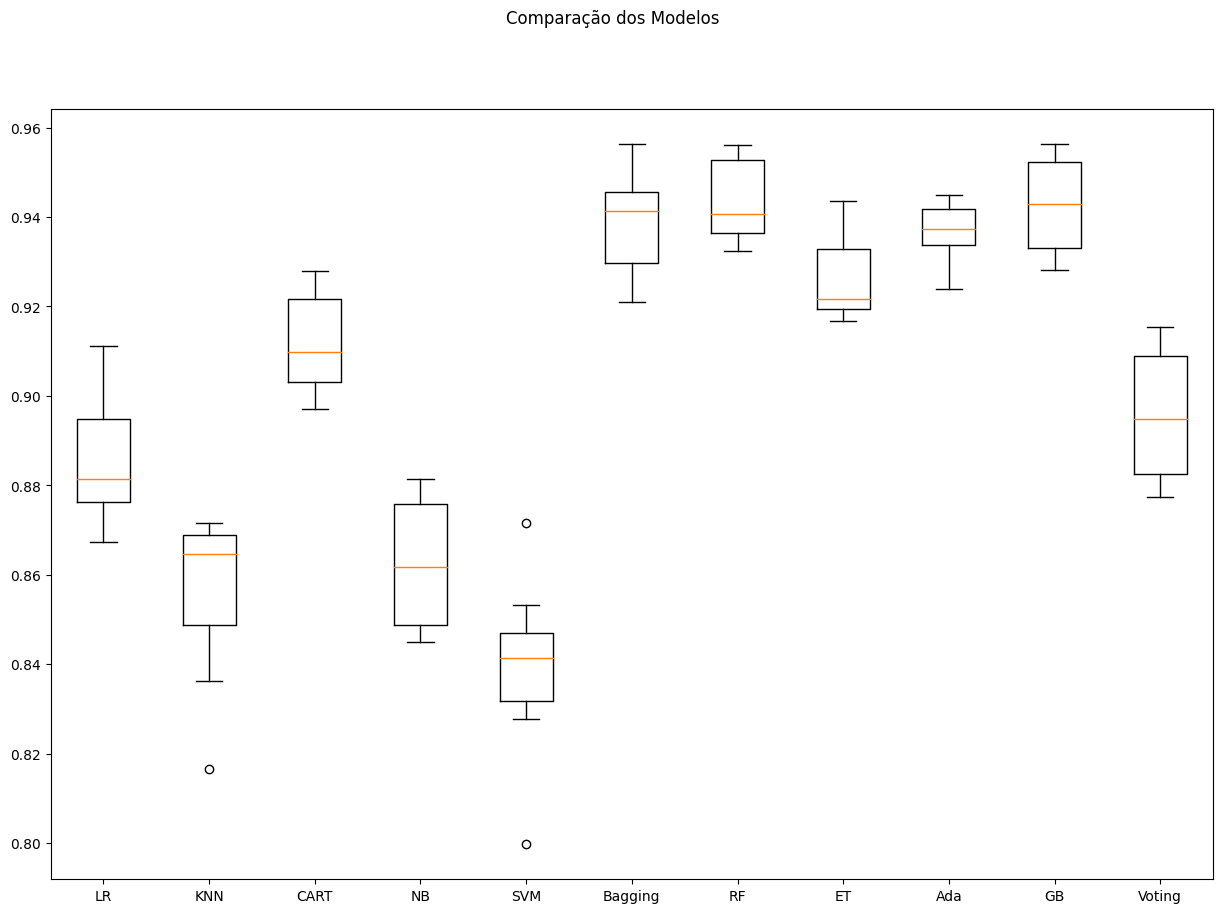

In [26]:
np.random.seed(8) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, x_treino, y_treino, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Criação e avaliação de modelos: dados padronizados e normalizados

LR-orig: 0.886 (0.014)
KNN-orig: 0.856 (0.017)
CART-orig: 0.912 (0.010)
NB-orig: 0.862 (0.014)
SVM-orig: 0.839 (0.018)
Bag-orig: 0.940 (0.011)
RF-orig: 0.944 (0.009)
ET-orig: 0.926 (0.009)
Ada-orig: 0.937 (0.007)
GB-orig: 0.943 (0.010)
Vot-orig: 0.896 (0.014)
LR-padr: 0.889 (0.013)
KNN-padr: 0.892 (0.014)
CART-padr: 0.915 (0.011)
NB-padr: 0.862 (0.014)
SVM-padr: 0.921 (0.014)
Bag-padr: 0.942 (0.010)
RF-padr: 0.942 (0.011)
ET-padr: 0.928 (0.012)
Ada-padr: 0.937 (0.007)
GB-padr: 0.943 (0.011)
Vot-padr: 0.922 (0.013)
LR-norm: 0.885 (0.015)
KNN-norm: 0.881 (0.013)
CART-norm: 0.915 (0.013)
NB-norm: 0.862 (0.014)
SVM-norm: 0.912 (0.013)
Bag-norm: 0.940 (0.011)
RF-norm: 0.943 (0.010)
ET-norm: 0.927 (0.010)
Ada-norm: 0.937 (0.007)
GB-norm: 0.942 (0.010)
Vot-norm: 0.912 (0.013)


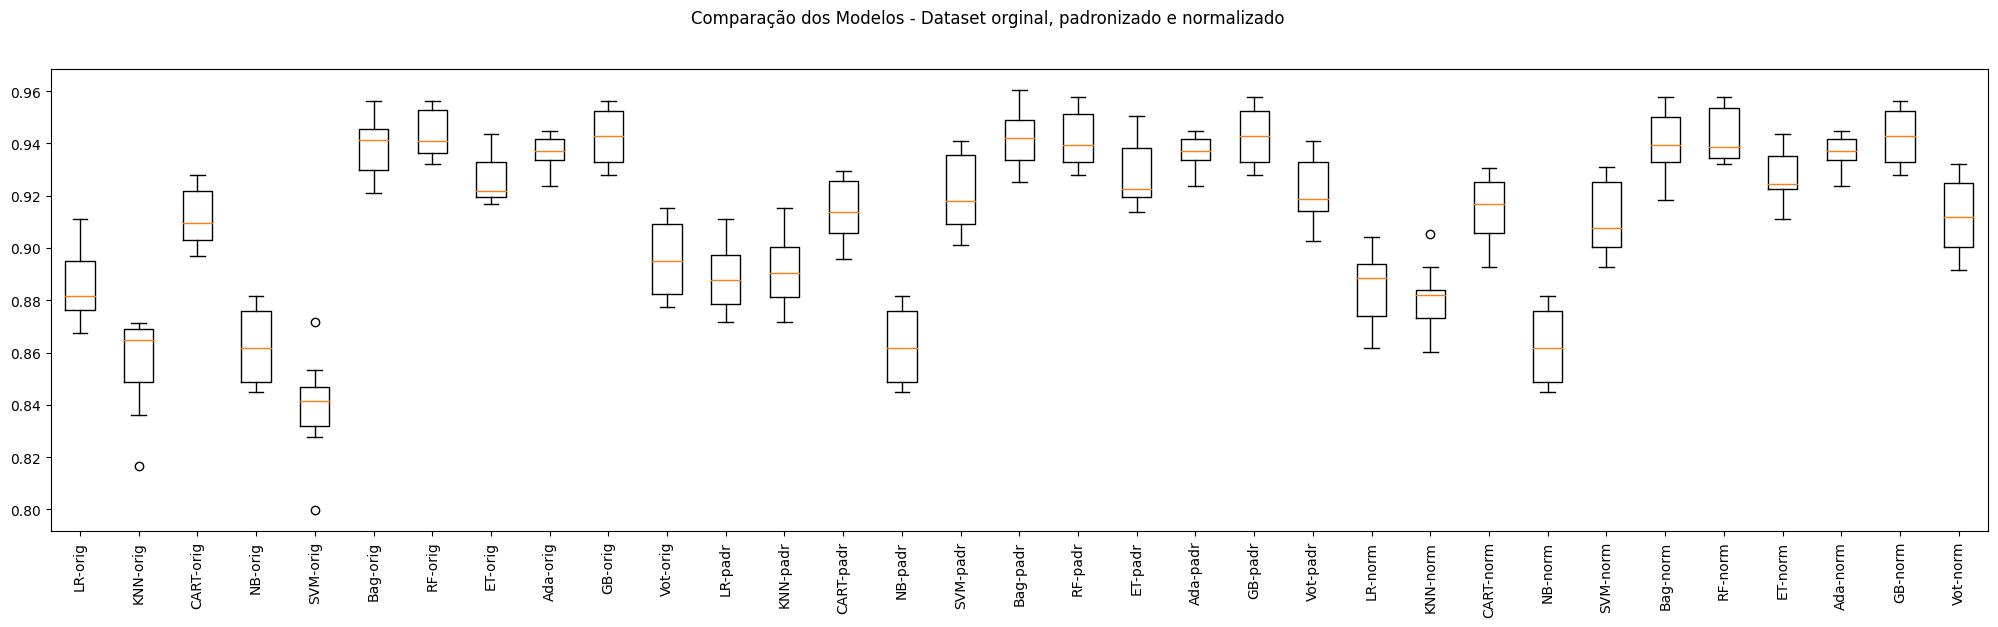

In [27]:
np.random.seed(8) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, x_treino, y_treino, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Otimização dos hiperparâmetros

In [28]:
# Tuning do RF

np.random.seed(8) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))

param_grid = {
    'RF__max_features': [1,3],
    'RF__verbose': [0,1],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Sem tratamento de missings: RF-orig - Melhor: 0.217270 usando {'RF__max_features': 3, 'RF__verbose': 0}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Sem tratamento de missings: RF-padr - Melhor: 0.215861 usando {'RF__max_features': 3, 'RF__verbose': 1}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Sem tratamento de missings: RF-norm - Melhor: 0.216847 usando {'RF__max_features': 3, 'RF__verbose': 1}


In [30]:
# Eliminação Recursiva de Atributos

# Criação do modelo
modelo = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)

# Eliminação Recursiva de Atributos
rfe = RFE(modelo, n_features_to_select=5)
fit = rfe.fit(X, y)

# Print dos resultados
print("Atributos Originais:", tabela.columns[:15])

# Exibe os atributos selecionados (marcados como True em "Atributos Selecionados"
# e com valor 1 em "Ranking dos Atributos")
print("\nAtributos Selecionados: %s" % fit.support_)
print("\nRanking de atributos: %s" % fit.ranking_)
print("\nQtd de melhores Atributos: %d" % fit.n_features_)
print("\nNomes dos Atributos Selecionados: %s" % fit.get_feature_names_out(input_features=tabela.columns[10:15]))

Atributos Originais: Index(['id', 'default', 'idade', 'sexo', 'dependentes', 'escolaridade',
       'estado_civil', 'salario_anual', 'tipo_cartao',
       'meses_de_relacionamento', 'qtd_produtos', 'iteracoes_12m',
       'meses_inativo_12m', 'limite_credito', 'valor_transacoes_12m'],
      dtype='object')

Atributos Selecionados: [ True  True  True  True  True]

Ranking de atributos: [1 1 1 1 1]

Qtd de melhores Atributos: 5

Nomes dos Atributos Selecionados: ['qtd_produtos' 'iteracoes_12m' 'meses_inativo_12m' 'limite_credito'
 'valor_transacoes_12m']


In [31]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(x_treino) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(x_treino) # aplicação da padronização no conjunto de treino
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
model.fit(rescaledX, y_treino)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(x_teste) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_teste, predictions))

0.9384666008555446


In [32]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(x) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(x) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

RandomForestClassifier(max_features=3)

In [33]:
# Treinando 100% da base para treino

model = RandomForestClassifier()
model.fit(x_treino, y_treino)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(x_teste)

# Estimando a acurácia no conjunto de teste
print(accuracy_score(y_teste, predictions))


0.9410990457387298


**Considerações finais:**

Os modelos apresentaram bons resultados, sendo capazes de prever uma possível  inadimplência do cliente, conforme proposta inicial.
O modelo escolhido que apresentou uma acurácia em torno de 94% foi o RandomForestClassifier.
Não foi observado overfitting.

**Observações:**
Foi utilizada a validação cruzada para treinar e avaliar os modelos usando a métrica acurácia.
Foi também utilizada a biblioteca Pipeline para criar e avaliar os modelos através da validação cruzada com os dados padronizados e normalizados, não apresentando diferença considerável do resultado dos modelos treinados com o dataset original.
Foi executada a otimização dos hiperparâmetros do algoritmo "RF" (algoritmo que apresentou melhor resultado) a fim de buscar resultados ainda melhores, porém, sem sucesso.






